In [1]:
import sys
import time
import os.path
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import numpy as np
from scipy.ndimage import gaussian_filter1d

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/utils/')
sys.path.insert(0, '/glade/u/home/ksha/PUBLISH/fcstpp/')

import data_utils as du
import graph_utils as gu
from fcstpp import utils as fu

from namelist import * 

In [2]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [5]:
# importing domain information
with h5py.File(save_dir+'BC_domain_info.hdf', 'r') as h5io:
    base_lon = h5io['base_lon'][...]
    base_lat = h5io['base_lat'][...]
    bc_lon = h5io['bc_lon'][...]
    bc_lat = h5io['bc_lat'][...]
    etopo_bc = h5io['etopo_bc'][...]
    land_mask = h5io['land_mask_base'][...]
    land_mask_bc = h5io['land_mask_bc'][...]

In [6]:
mon_rain = np.array([9, 10, 11, 0, 1, 2])
mon_dry = np.array([3, 4, 5, 6, 7, 8])

base = datetime(2017, 1, 1)
date_list = [base + timedelta(days=x) for x in range(365+365+365)]

rain_inds = np.zeros((len(date_list),), dtype=bool)
dry_inds = np.zeros((len(date_list),), dtype=bool)

mon_inds = []
for d, date in enumerate(date_list):
    
    mon_inds.append(date.month-1)
    if date.month-1 in mon_dry:
        dry_inds[d] = True
    else:
        rain_inds[d] = True

mon_inds = np.array(mon_inds)

fcst_leads = np.arange(3, 72*3+3, 3, dtype=np.float)
fcst_leads_ini = np.arange(0, 72*3+3, 3, dtype=np.float)
date_base = datetime(2019, 1, 1, 0)

UTC_H = []
DAYS = []
for lead in fcst_leads_ini:
    date_temp = date_base + timedelta(hours=lead)
    UTC_H.append(date_temp.hour)
    DAYS.append(date_temp.day-1)
    
DAYS = np.array(DAYS)
day_inds = DAYS[2:56]

In [7]:
# three watershed groups
with h5py.File(save_dir+'BCH_wshed_groups.hdf', 'r') as h5io:
    flag_sw = h5io['flag_sw'][...]
    flag_si = h5io['flag_si'][...]
    flag_n = h5io['flag_n'][...]
    
FLAGs = (flag_sw, flag_si, flag_n)

In [8]:
# from scipy.stats import wilcoxon

# def BS_boost_(BS, mon_inds, day_inds, bootstrap_n=100):

#     N_fcst_day = np.max(day_inds)+1
#     data_boost = np.empty((12, N_fcst_day, bootstrap_n))
    
#     for mon in range(12):
#         #temp = BS[mon_inds==mon, ...]
        
#         if mon == 0:
#             temp = np.concatenate((BS[mon_inds==11, ...], 
#                                    BS[mon_inds==0, ...], 
#                                    BS[mon_inds==1, ...]), axis=0)                       
#         elif mon == 11:
#             temp = np.concatenate((BS[mon_inds==10, ...], 
#                                    BS[mon_inds==11, ...], 
#                                    BS[mon_inds==0, ...]), axis=0)
#         else:
#             temp = np.concatenate((BS[mon_inds==mon-1, ...], 
#                                    BS[mon_inds==mon, ...], 
#                                    BS[mon_inds==mon+1, ...]), axis=0)
        
#         for fcst_day in range(N_fcst_day):
            
#             data_sub = temp[:, day_inds==fcst_day].ravel()
#             flag_nan = np.logical_not(np.isnan(data_sub))
#             L = np.sum(flag_nan)
#             temp_sub = data_sub[flag_nan]

#             # bootstrap cycles
#             for b in range(bootstrap_n):

#                 ind_bagging = np.random.choice(L, size=L, replace=True)
#                 data_boost[mon, fcst_day, b] = np.mean(temp_sub[ind_bagging])
                
#     return np.mean(data_boost, axis=-1), np.std(data_boost, axis=-1)

# def BS_per_mon(BS, mon_inds):
#     base_rain_mon = np.empty((12, 54))
#     for mon in range(12):
#         #temp = BS[mon_inds==mon, ...]
#         if mon == 0:
#             temp = np.concatenate((BS[mon_inds==11, ...], 
#                                    BS[mon_inds==0, ...], 
#                                    BS[mon_inds==1, ...]), axis=0)                       
#         elif mon == 11:
#             temp = np.concatenate((BS[mon_inds==10, ...], 
#                                    BS[mon_inds==11, ...], 
#                                    BS[mon_inds==0, ...]), axis=0)
#         else:
#             temp = np.concatenate((BS[mon_inds==mon-1, ...], 
#                                    BS[mon_inds==mon, ...], 
#                                    BS[mon_inds==mon+1, ...]), axis=0)
#         base_rain_mon[mon, :] = np.nanmean(temp, axis=0)
            
#     return base_rain_mon

# def lead_to_day(BSS_mon, day_inds):
#     N_day = np.max(day_inds)+1
#     out = np.empty((12, N_day))
#     for i in range(N_day):
#         out_temp = np.nanmean(BSS_mon[:, day_inds==i], axis=1)
#         out[:, i] = out_temp
#     return out

# def wilcoxon_by_mon_leads(FCST1, FCST2, mon_inds, day_inds):
#     L = np.max(day_inds) + 1
    
#     w_stat = np.empty((12, L,))
#     p_vals = np.empty((12, L,))
    
#     series1 = FCST1
#     series2 = FCST2
    
#     for m in range(12):
#         flag_m = mon_inds==m
        
#         for i in range(L):
#             flag_d = day_inds == i
            
#             d1 = series1[flag_m, :][:, day_inds==i]
#             d2 = series2[flag_m, :][:, day_inds==i]
            
#             w_, p_ = wilcoxon(d1.ravel(), d2.ravel(),)
#             w_stat[m, i] = w_
#             p_vals[m, i] = p_
            
#     return w_stat, p_vals

# with h5py.File(save_dir+'GEFS_BS_BCH_2017.hdf', 'r') as h5io:
#     GEFS_BS_17 = h5io['BS'][...] 
# with h5py.File(save_dir+'GEFS_BS_BCH_2018.hdf', 'r') as h5io:
#     GEFS_BS_18 = h5io['BS'][...]
# with h5py.File(save_dir+'GEFS_BS_BCH_2019.hdf', 'r') as h5io:
#     GEFS_BS_19 = h5io['BS'][...]
    
# with h5py.File(save_dir+'BASE_final_BS_BCH_2017.hdf', 'r') as h5io:
#     BASE_BS_17 = h5io['BS'][...] 
# with h5py.File(save_dir+'BASE_final_BS_BCH_2018.hdf', 'r') as h5io:
#     BASE_BS_18 = h5io['BS'][...]
# with h5py.File(save_dir+'BASE_final_BS_BCH_2019.hdf', 'r') as h5io:
#     BASE_BS_19 = h5io['BS'][...]
    
# with h5py.File(save_dir+'SL_final_BS_BCH_2017.hdf', 'r') as h5io:
#     SL_BS_17 = h5io['BS'][...] 
# with h5py.File(save_dir+'SL_final_BS_BCH_2018.hdf', 'r') as h5io:
#     SL_BS_18 = h5io['BS'][...]
# with h5py.File(save_dir+'SL_final_BS_BCH_2019.hdf', 'r') as h5io:
#     SL_BS_19 = h5io['BS'][...]
    
# with h5py.File(save_dir+'BASE_CNN_BS_BCH_2017.hdf', 'r') as h5io:
#     BCNN_BS_17 = h5io['BS'][...] 
# with h5py.File(save_dir+'BASE_CNN_BS_BCH_2018.hdf', 'r') as h5io:
#     BCNN_BS_18 = h5io['BS'][...]
# with h5py.File(save_dir+'BASE_CNN_BS_BCH_2019.hdf', 'r') as h5io:
#     BCNN_BS_19 = h5io['BS'][...]
    
# with h5py.File(save_dir+'SL_CNN_BS_BCH_2017.hdf', 'r') as h5io:
#     SCNN_BS_17 = h5io['BS'][...] 
# with h5py.File(save_dir+'SL_CNN_BS_BCH_2018.hdf', 'r') as h5io:
#     SCNN_BS_18 = h5io['BS'][...]
# with h5py.File(save_dir+'SL_CNN_BS_BCH_2019.hdf', 'r') as h5io:
#     SCNN_BS_19 = h5io['BS'][...]
    
# with h5py.File(save_dir+'CLIM_BS_BCH_2017.hdf', 'r') as h5io:
#     CLIM_BS_17 = h5io['BS'][...] 
# with h5py.File(save_dir+'CLIM_BS_BCH_2018.hdf', 'r') as h5io:
#     CLIM_BS_18 = h5io['BS'][...]
# with h5py.File(save_dir+'CLIM_BS_BCH_2019.hdf', 'r') as h5io:
#     CLIM_BS_19 = h5io['BS'][...]

# for i in range(3):
#     BASE_BS = np.concatenate((BASE_BS_17, BASE_BS_18, BASE_BS_19), axis=0)[..., FLAGs[i]]
#     SL_BS   = np.concatenate((SL_BS_17, SL_BS_18, SL_BS_19), axis=0)[..., FLAGs[i]]
#     BCNN_BS = np.concatenate((BCNN_BS_17, BCNN_BS_18, BCNN_BS_19), axis=0)[..., FLAGs[i]]
#     SCNN_BS = np.concatenate((SCNN_BS_17, SCNN_BS_18, SCNN_BS_19), axis=0)[..., FLAGs[i]]
#     GEFS_BS = np.concatenate((GEFS_BS_17, GEFS_BS_18, GEFS_BS_19), axis=0)[..., FLAGs[i]]
#     CLIM_BS = np.concatenate((CLIM_BS_17, CLIM_BS_18, CLIM_BS_19), axis=0)[..., FLAGs[i]]

#     BSS_wilcox = {}

#     w_stat, p_vals = wilcoxon_by_mon_leads(BCNN_BS, BASE_BS, mon_inds, DAYS[2:56])
#     BSS_wilcox['bcnn_base'] = p_vals

#     w_stat, p_vals = wilcoxon_by_mon_leads(SCNN_BS, SL_BS, mon_inds, DAYS[2:56])
#     BSS_wilcox['scnn_sl'] = p_vals

#     w_stat, p_vals = wilcoxon_by_mon_leads(SL_BS, BASE_BS, mon_inds, DAYS[2:56])
#     BSS_wilcox['sl_base'] = p_vals

#     w_stat, p_vals = wilcoxon_by_mon_leads(SCNN_BS, BCNN_BS, mon_inds, DAYS[2:56])
#     BSS_wilcox['scnn_bcnn'] = p_vals
    
#     # climatology reference not bootstrapped (?)
#     CLIM_BS_lead = lead_to_day(BS_per_mon(np.nansum(CLIM_BS, axis=-1), mon_inds), DAYS[2:56])
        
#     GEFS_BS_lead, GEFS_BS_std = BS_boost_(np.sum(GEFS_BS, axis=-1), mon_inds, DAYS[2:56], bootstrap_n=100)
#     BASE_BS_lead, BASE_BS_std = BS_boost_(np.sum(BASE_BS, axis=-1), mon_inds, DAYS[2:56], bootstrap_n=100)
#     SL_BS_lead, SL_BS_std = BS_boost_(np.sum(SL_BS, axis=-1), mon_inds, DAYS[2:56], bootstrap_n=100)
#     BCNN_BS_lead, BCNN_BS_std = BS_boost_(np.sum(BCNN_BS, axis=-1), mon_inds, DAYS[2:56], bootstrap_n=100)
#     SCNN_BS_lead, SCNN_BS_std = BS_boost_(np.sum(SCNN_BS, axis=-1), mon_inds, DAYS[2:56], bootstrap_n=100)
    
#     # ----- #
#     BSS_dict = {}
#     BSS_dict['{}'.format('gfs')] = 1-GEFS_BS_lead/CLIM_BS_lead
#     BSS_dict['{}'.format('base')] = 1-BASE_BS_lead/CLIM_BS_lead
#     BSS_dict['{}'.format('sl')] = 1-SL_BS_lead/CLIM_BS_lead
#     BSS_dict['{}'.format('bcnn')] = 1-BCNN_BS_lead/CLIM_BS_lead
#     BSS_dict['{}'.format('scnn')] = 1-SCNN_BS_lead/CLIM_BS_lead
    
#     BSS_std = {}
#     BSS_std['{}'.format('gfs')] = GEFS_BS_std/CLIM_BS_lead
#     BSS_std['{}'.format('base')] = BASE_BS_std/CLIM_BS_lead
#     BSS_std['{}'.format('sl')] = SL_BS_std/CLIM_BS_lead
#     BSS_std['{}'.format('bcnn')] = BCNN_BS_std/CLIM_BS_lead
#     BSS_std['{}'.format('scnn')] = SCNN_BS_std/CLIM_BS_lead


    
#     np.save(save_dir+'BSS_BCH_loc{}.npy'.format(i), BSS_dict)
#     np.save(save_dir+'BSS_BCH_std_loc{}.npy'.format(i), BSS_std)
#     np.save(save_dir+'BSS_BCH_wilcox_loc{}.npy'.format(i), BSS_wilcox)

## Exploring 90-th thresholds

In [9]:
with h5py.File(save_dir+'BCH_ERA5_3H_verif.hdf', 'r') as h5io:
    BCH_obs = h5io['BCH_obs'][...]
    indx = h5io['indx'][...]
    indy = h5io['indy'][...]

# importing domain info
with h5py.File(save_dir+'BC_domain_info.hdf', 'r') as h5io:
    land_mask_bc = h5io['land_mask_bc'][...]

# importing girdded ERA5 quantiles
with h5py.File(ERA_dir+'PT_3hour_q.hdf', 'r') as h5io:
    CDF_era = h5io['era_3hq_bc'][...]
    q_bins = h5io['q_bins'][...]

CDF_obs = np.empty((12, 107,)+land_mask_bc.shape)
CDF_obs[..., ~land_mask_bc] = CDF_era
CDF_obs = CDF_obs[..., indx, indy]

# station and monthly (contains neighbouring months) wise 90th
BCH_90th = CDF_obs[:, 93, :]

# Figures by watersh regions

In [10]:
def setBoxColors(bp, c, m, lw):
    plt.setp(bp['boxes'][0], color=c, linewidth=lw)
    plt.setp(bp['caps'][0], color=c, linewidth=lw)
    plt.setp(bp['caps'][1], color=c, linewidth=lw)
    plt.setp(bp['whiskers'][0], color=c, linewidth=lw)
    plt.setp(bp['whiskers'][1], color=c, linewidth=lw)
    plt.setp(bp['medians'][0], color=m, linewidth=lw)

In [11]:
cmap_pct, A = gu.precip_cmap()

In [12]:
methods = ['gfs', 'base', 'sl', 'bcnn', 'scnn']

fake_x = np.arange(12) # inds of Jan-Dec
LS = ['-',]*8
C = ['0.25', A[3, :], A[2, :], A[4, :], A[6, :], A[13, :], A[10, :]] # line color
C_M = [A[0, :], A[3, :], A[2, :], A[4, :], A[6, :], A[13, :], A[10, :]] # marker face color
M = ['o', '^', 's', '<', 's', '>', 'o'] # marker types
gray = [0.5, 0.5, 0.5]
fontsize = 13.5

## South Coast

In [13]:
BSS_dict = np.load(save_dir+'BSS_BCH_loc0.npy', allow_pickle=True)[()]
BSS_std_dict = np.load(save_dir+'BSS_BCH_std_loc0.npy', allow_pickle=True)[()]
BSS_wilcox = np.load(save_dir+'BSS_BCH_wilcox_loc0.npy', allow_pickle=True)[()]

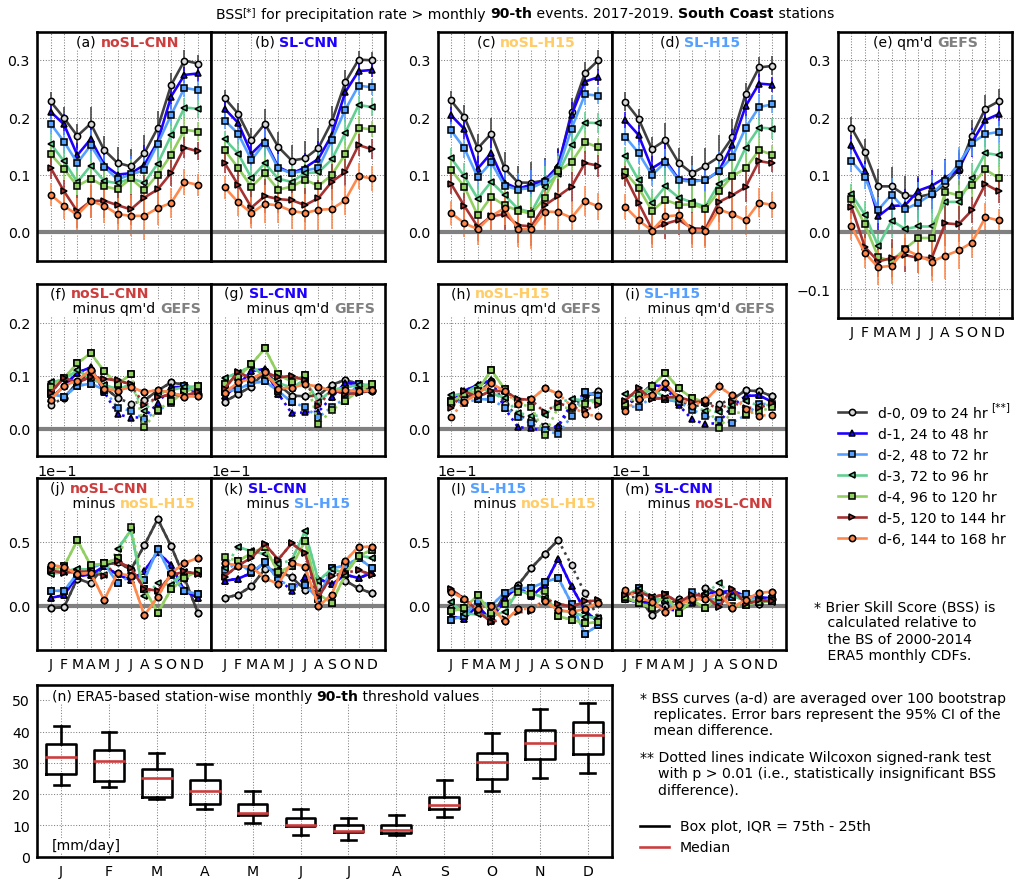

In [14]:
# 1st row
YLIM0 = [-0.05, 0.35]
YLIM1 = [-0.05, 0.35]
YLIM = YLIM1
YLIM_gfs = [-0.15, 0.35]

# 2nd row
YLIM_diff00 = [-0.05, 0.275]
YLIM_diff01 = [-0.05, 0.275]

# 3rd row
YLIM_diff1 = [-0.035, 0.1]
YLIM_diff2 = [-0.035, 0.1]

labels = ['d-0, 09 to 24 hr', 
          'd-1, 24 to 48 hr', 
          'd-2, 48 to 72 hr', 
          'd-3, 72 to 96 hr', 
          'd-4, 96 to 120 hr', 
          'd-5, 120 to 144 hr',
          'd-6, 144 to 168 hr']

h_ratio = np.array([1, 0.1, 0.75, 0.1, 0.75, 0.15, 0.75])
w_ratio = np.array([1, 1, 0.3, 1, 1, 0.3, 1])

fig = plt.figure(figsize=(13, 11), dpi=dpi_)
gs = gridspec.GridSpec(7, 7, height_ratios=h_ratio, width_ratios=w_ratio)

ax00 = plt.subplot(gs[0, 0]); ax01 = plt.subplot(gs[0, 1]); ax02 = plt.subplot(gs[0, 3]); ax03 = plt.subplot(gs[0, 4]);
ax10 = plt.subplot(gs[2, 0]); ax11 = plt.subplot(gs[2, 1]); ax12 = plt.subplot(gs[2, 3]); ax13 = plt.subplot(gs[2, 4]);
ax20 = plt.subplot(gs[4, 0]); ax21 = plt.subplot(gs[4, 1]); ax22 = plt.subplot(gs[4, 3]); ax23 = plt.subplot(gs[4, 4]);
ax_box = plt.subplot(gs[6, :4])

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

AX0 = [ax00, ax01, ax02, ax03]
AX1 = [ax10, ax11, ax12, ax13]
AX2 = [ax20, ax21, ax22, ax23]

AX_bss = [AX0,]
AX_diff = [AX1, AX2]

handle_title = []
handle_lines = []

wx = 1.0/w_ratio.sum()
dx = 4.6/w_ratio.sum()
hx = 1.0/h_ratio.sum()
locx = 1.0

AX_gfs = []
h_ = hx*(YLIM_gfs[1]-YLIM_gfs[0])/(YLIM[1]-YLIM[0]) 
AX_gfs.append(fig.add_axes([dx, locx-h_, wx, h_]))

AX_all = AX0 + AX1 + AX2 + AX_gfs

AX_left = [ax00, ax02, ax10, ax12, ax20, ax22, AX_gfs[0]]
AX_bottom = [ax20, ax21, ax22, ax23, AX_gfs[0]]

for i, ax in enumerate(AX_all):
    ax = gu.ax_decorate_box(ax)
    
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    
    ax.grid(linewidth=1.0, linestyle=':', color='0.5')
    ax.set_xlim([-1, 12])
    ax.set_xticks(fake_x)
    ax.axhline(0, xmin=0, xmax=1.0, linewidth=4.0, linestyle='-', color='0.5', zorder=2)
    
for ax in AX_left:
    ax.tick_params(labelleft=True)

for ax in AX_bottom:
    ax.tick_params(labelbottom=True)
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])

    
ax_box = gu.ax_decorate_box(ax_box)
ax_box.xaxis.set_tick_params(labelsize=fontsize)
ax_box.yaxis.set_tick_params(labelsize=fontsize)
ax_box.set_ylim([0, 55])
ax_box.grid(linewidth=1.0, linestyle=':', color='0.5')
ax_box.tick_params(labelleft=True)
ax_box.tick_params(labelbottom=True)
ax_box.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
handle_title.append(ax_box.text(0.025, 0.025, '[mm/day]', ha='left', va='bottom', 
                                fontsize=fontsize, transform=ax_box.transAxes))



methods_plot = ['bcnn', 'scnn', 'base', 'sl']

methods_diff1 = ['bcnn', 'scnn', 'sl', 'scnn']
methods_diff2 = ['base', 'sl', 'base', 'bcnn']

fontsize_list = [fontsize,]*5
fontweight_list = ['normal', 'bold', 'normal', 'bold', 'normal']

x_start0 = 0.225
y_start0 = 0.985

x_start1 = 0.2
y_start1 = 0.9825

x_start2 = 0.075
y_start2 = 0.9825

dd = 0.085
handle_title += gu.string_partial_format(fig, ax00, x_start0, y_start0, 'left', 'top', 
                                         ['(a) ', 'noSL-CNN', ], ['k', red], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax01, x_start0+0.025, y_start0, 'left', 'top', 
                                         ['(b) ', 'SL-CNN', ], ['k', blue], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax02, x_start0, y_start0, 'left', 'top', 
                                         ['(c) ', 'noSL-H15', ], ['k', orange], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax03, x_start0+0.05, y_start0, 'left', 'top', 
                                         ['(d) ', 'SL-H15', ], ['k', cyan], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, AX_gfs[0], x_start1, 1-(1-y_start1)*(hx/h_)+0.0025, 'left', 'top', 
                                         ["(e) qm'd ", 'GEFS'], ['k', gray], [fontsize,]*2,  ['normal', 'bold'])

handle_title += gu.string_partial_format(fig, ax10, x_start2, y_start2, 'left', 'top', 
                                         ['(f) ', 'noSL-CNN', ], ['k', red], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax10, x_start2, y_start2-dd, 'left', 'top', 
                                         ["     minus qm'd ", 'GEFS'], ['k', gray], fontsize_list, fontweight_list)

handle_title += gu.string_partial_format(fig, ax11, x_start2, y_start2, 'left', 'top', 
                                         ['(g) ', 'SL-CNN'], ['k', blue], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax11, x_start2, y_start2-dd, 'left', 'top', 
                                         ["     minus qm'd ", 'GEFS'], ['k', gray], fontsize_list, fontweight_list)

handle_title += gu.string_partial_format(fig, ax12, x_start2, y_start2, 'left', 'top', 
                                         ['(h) ', 'noSL-H15'], ['k', orange], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax12, x_start2, y_start2-dd, 'left', 'top', 
                                         ["     minus qm'd ", 'GEFS'], ['k', gray], fontsize_list, fontweight_list)

handle_title += gu.string_partial_format(fig, ax13, x_start2, y_start2, 'left', 'top', 
                                         ['(i) ', 'SL-H15'], ['k', cyan,], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax13, x_start2, y_start2-dd, 'left', 'top', 
                                         ["     minus qm'd ", 'GEFS'], ['k', gray], fontsize_list, fontweight_list)

handle_title += gu.string_partial_format(fig, ax20, x_start2, y_start2, 'left', 'top', 
                                         ['(j) ', 'noSL-CNN', ], ['k', red], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax20, x_start2, y_start2-dd, 'left', 'top', 
                                         ['     minus ', 'noSL-H15'], ['k', orange], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax21, x_start2, y_start2, 'left', 'top', 
                                         ['(k) ', 'SL-CNN'], ['k', blue], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax21, x_start2, y_start2-dd, 'left', 'top', 
                                         ['     minus ', 'SL-H15'], ['k', cyan], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax22, x_start2, y_start2, 'left', 'top', 
                                         ['(l) ', 'SL-H15'], ['k', cyan,], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax22, x_start2, y_start2-dd, 'left', 'top', 
                                         ['     minus ', 'noSL-H15'], ['k', orange], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax23, x_start2, y_start2, 'left', 'top', 
                                         ['(m) ', 'SL-CNN'], ['k', blue], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax23, x_start2, y_start2-dd, 'left', 'top', 
                                         ['     minus ', 'noSL-CNN'], ['k', red], fontsize_list, fontweight_list)

# BSS and diff curves

AX_bss[0][0].set_ylim(YLIM0)
AX_bss[0][1].set_ylim(YLIM0)
AX_bss[0][2].set_ylim(YLIM1)
AX_bss[0][3].set_ylim(YLIM1)

AX_diff[0][0].set_ylim(YLIM_diff00)
AX_diff[0][1].set_ylim(YLIM_diff00)
AX_diff[0][2].set_ylim(YLIM_diff01)
AX_diff[0][3].set_ylim(YLIM_diff01)

AX_diff[1][0].set_ylim(YLIM_diff1)
AX_diff[1][1].set_ylim(YLIM_diff1)
AX_diff[1][2].set_ylim(YLIM_diff2)
AX_diff[1][3].set_ylim(YLIM_diff2)

AX_gfs[0].set_ylim(YLIM_gfs)
    
for d in range(7):
    AX_gfs[0].errorbar(fake_x, y=BSS_dict['gfs'][:, d], yerr=BSS_std_dict['gfs'][:, d],
                                       linewidth=2.5, linestyle=LS[d], color=C[d], marker=M[d], mfc=C_M[d], 
                                       ms=6, mec='k', mew=1.5, elinewidth=1.5, barsabove=False)
for m, method in enumerate(methods_plot):
    for d in range(7):
        AX_bss[0][m].errorbar(fake_x, y=BSS_dict['{}'.format(method)][:, d], yerr=BSS_std_dict['{}'.format(method)][:, d], 
                              linewidth=2.5, linestyle=LS[d], color=C[d], marker=M[d], mfc=C_M[d], ms=6, mec='k', mew=1.5,
                              elinewidth=1.5, barsabove=False)        
        
#         AX_bss[0][m].plot(fake_x, BSS_dict['{}'.format(method)][:, d], linewidth=2.5, 
#                           linestyle=LS[d], color=C[d], marker=M[d], mfc=C_M[d], ms=6, mec='k', mew=1.5)
        
        diff_temp = BSS_dict['{}'.format(method)]-BSS_dict['gfs']
        diff_temp_sig = np.copy(diff_temp)
        diff_temp_sig[np.abs(diff_temp_sig)<0.05] = np.nan
        
        AX_diff[0][m].plot(fake_x, diff_temp[:, d], linewidth=2.5, 
                           linestyle=':', color=C[d], marker=M[d], mfc=C_M[d], ms=6, mec='k', mew=1.5)
        AX_diff[0][m].plot(fake_x, diff_temp_sig[:, d], linewidth=2.5, 
                           linestyle='-', color=C[d], marker=M[d], mfc=C_M[d], ms=6, mec='k', mew=1.5)        
        
        diff_temp = BSS_dict['{}'.format(methods_diff1[m])]-BSS_dict['{}'.format(methods_diff2[m])]
        diff_p = BSS_wilcox['{}_{}'.format(methods_diff1[m], methods_diff2[m])]
        diff_temp_sig = np.copy(diff_temp)
        diff_temp_sig[diff_p>0.01] = np.nan
        
        
        AX_diff[1][m].plot(fake_x, diff_temp[:, d], linewidth=2.5, 
                           linestyle=':', color=C[d], marker=M[d], mfc=C_M[d], ms=6, mec='k', mew=1.5)
        AX_diff[1][m].plot(fake_x, diff_temp_sig[:, d], linewidth=2.5, 
                           linestyle='-', color=C[d], marker=M[d], mfc=C_M[d], ms=6, mec='k', mew=1.5)

dict_c = dict(marker='o', ms=8, mew=1.5, mfc='none')

for i in range(12):
    loc = i
    temp_ = 8*BCH_90th[i, FLAGs[0]]
    handle_boxp = ax_box.boxplot(temp_, positions=[loc,], flierprops=dict_c, widths=0.618)
    setBoxColors(handle_boxp, 'k', red, 2.5)
        
handle_lines = []
for d in range(7):
    handle_lines.append(mlines.Line2D([], [], linewidth=2.5, linestyle=LS[d], 
                                      color=C[d], marker=M[d], mfc=C_M[d], ms=6, 
                                      mec='k', mew=1.5, label=labels[d]))
    
for i in range(2):
    AX_bss[0][i].set_yticks([0, 0.1, 0.2, 0.3])

for i in range(2, 4):
    AX_bss[0][i].set_yticks([0, 0.1, 0.2, 0.3])
    
AX_gfs[0].set_yticks([-0.1, 0, 0.1, 0.2, 0.3])

for i in [0, 1]:
    AX_diff[0][i].set_yticks([0, 0.1, 0.2]);
    
for i in [2, 3]:
    AX_diff[0][i].set_yticks([0, 0.1, 0.2]);
    
for i in [0, 1]:
    AX_diff[1][i].ticklabel_format(axis='y', scilimits=(-1, -1))
    AX_diff[1][i].set_yticks([0, 0.05,]);
    AX_diff[1][i].yaxis.offsetText.set_fontsize(14)

for i in [2, 3]:
    AX_diff[1][i].ticklabel_format(axis='y', scilimits=(-1, -1))
    AX_diff[1][i].set_yticks([0, 0.05,]);
    AX_diff[1][i].yaxis.offsetText.set_fontsize(14)
    
# ---------- title ---------- #
ax_t1 = fig.add_axes([0.5*(5.6-3.55)/5.6, 1.0, (3.55/5.6), 0.03])
ax_t1.set_axis_off()
handle_title += gu.string_partial_format(fig, ax_t1, 0, 1.0, 'left', 'top', 
                ['BSS    for precipitation rate > monthly ', '90-th', ' events. 2017-2019. ', 'South Coast', ' stations'], 
                ['k',]*5, fontsize_list, ['normal', 'bold', 'normal', 'bold', 'normal'])

handle_title.append(ax_t1.text(0.0435, 0.999, '[*]', ha='left', va='top', fontsize=10, transform=ax_t1.transAxes))

handle_title += gu.string_partial_format(fig, ax_box, 0.025, 0.975, 'left', 'top', 
                ['(n) ERA5-based station-wise monthly ', '90-th', ' threshold values'], 
                ['k',]*3, fontsize_list, ['normal', 'bold', 'normal'])

# ---------- legend and words ---------- #
pad = 0.0

# legend BSS lines
ax_lg1 = fig.add_axes([4.6/5.6, 0.925/3.6-pad, 1/5.6, 1/3.2])
ax_lg1.set_axis_off()
LG1 = ax_lg1.legend(handles=handle_lines, bbox_to_anchor=(1.035, 0.975), 
                    ncol=1, prop={'size':fontsize}, fancybox=False);
LG1.get_frame().set_facecolor('none')
LG1.get_frame().set_linewidth(0)
LG1.get_frame().set_alpha(1.0)

# words
handle_title.append(ax_lg1.text(0.88, 0.945, '[**]', ha='left', va='top', fontsize=10, transform=ax_lg1.transAxes))

ax_w1 = fig.add_axes([4.6/5.6-0.025, (0.7)/3.6-pad, 1/5.6+0.025, 0.375/3.2])
ax_w1.set_axis_off()
ax_w1.text(0, 1, '* Brier Skill Score (BSS) is\n   calculated relative to\n   the BS of 2000-2014\n   ERA5 monthly CDFs.', 
          ha='left', va='top', fontsize=fontsize, transform=ax_w1.transAxes);

ax_w2 = fig.add_axes([3.6/5.6-0.025, (0.3)/3.6-pad, 1/5.6+0.025, 0.375/3.2])
ax_w2.set_axis_off()
ax_w2.text(0, 1, '* BSS curves (a-d) are averaged over 100 bootstrap\n   replicates. Error bars represent the 95% CI of the\n   mean difference.', 
          ha='left', va='top', fontsize=fontsize, transform=ax_w2.transAxes);

ax_w3 = fig.add_axes([3.6/5.6-0.025, (-0.1)/3.6-pad, 1/5.6+0.025, 0.5/3.2])
ax_w3.set_axis_off()
ax_w3.text(0, 1, 
           '** Dotted lines indicate Wilcoxon signed-rank test\n    with p > 0.01 (i.e., statistically insignificant BSS\n    difference).', 
           ha='left', va='top', fontsize=fontsize, transform=ax_w3.transAxes);

# legend box plot
ax_lg2 = fig.add_axes([3.6/5.6-0.025, (0.0)/3.6-pad, 0.25, 0.06])
ax_lg2.set_axis_off()
LG2 = ax_lg2.legend([handle_boxp["boxes"][0], handle_boxp["medians"][0]],
                   ['Box plot, IQR = 75th - 25th', 'Median'], 
                   bbox_to_anchor=(1, 1), ncol=1, prop={'size':fontsize})
LG2.get_frame().set_facecolor('none')
LG2.get_frame().set_linewidth(0)
LG2.get_frame().set_alpha(1.0)
# -------------------------------------- #

for handle in handle_title:
    handle.set_bbox(dict(facecolor='w', pad=0.5, edgecolor='none', zorder=2))

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'AnEn_BCH_BSS_SouthCoast.png', format='png', **fig_keys)

## Southern Interior

In [15]:
BSS_dict = np.load(save_dir+'BSS_BCH_loc1.npy', allow_pickle=True)[()]
BSS_std_dict = np.load(save_dir+'BSS_BCH_std_loc1.npy', allow_pickle=True)[()]
BSS_wilcox = np.load(save_dir+'BSS_BCH_wilcox_loc1.npy', allow_pickle=True)[()]

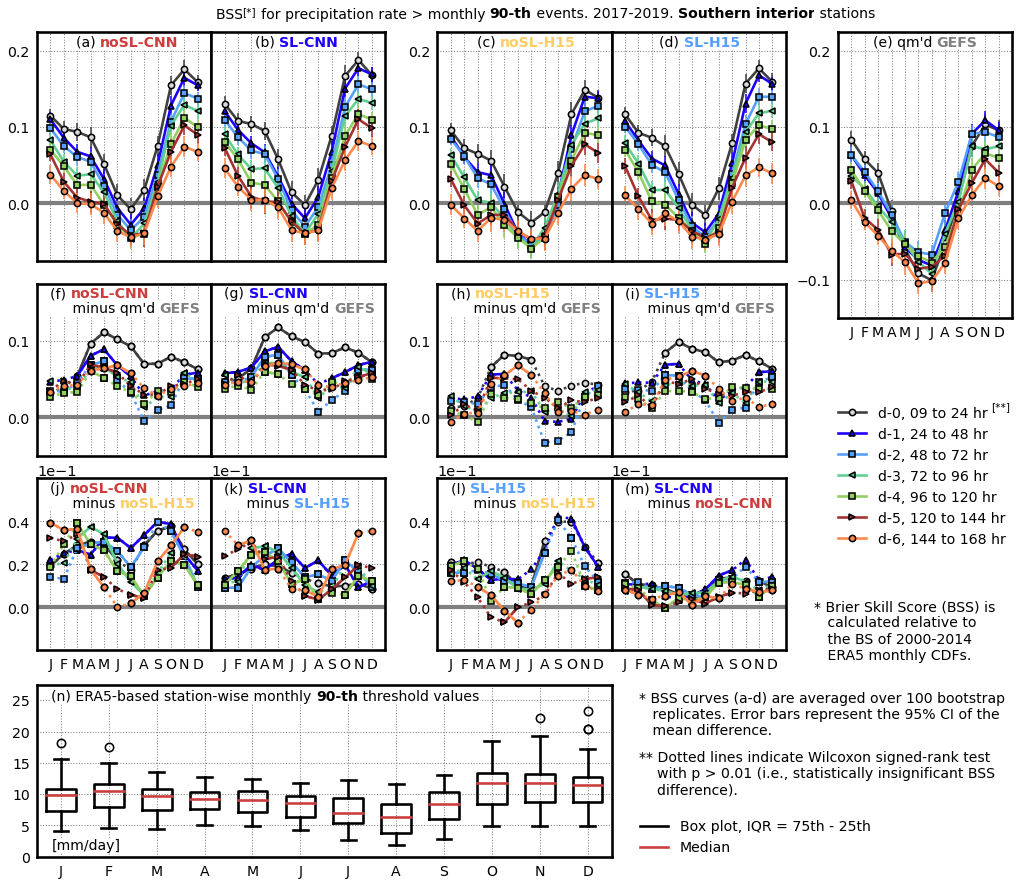

In [16]:
# 1st row
YLIM0 = [-0.075, 0.225]
YLIM1 = [-0.075, 0.225]
YLIM = YLIM1
YLIM_gfs = [-0.15, 0.225]

# 2nd row
YLIM_diff00 = [-0.05, 0.175]
YLIM_diff01 = [-0.05, 0.175]

# 3rd row
YLIM_diff1 = [-0.02, 0.06]
YLIM_diff2 = [-0.02, 0.06]

labels = ['d-0, 09 to 24 hr', 
          'd-1, 24 to 48 hr', 
          'd-2, 48 to 72 hr', 
          'd-3, 72 to 96 hr', 
          'd-4, 96 to 120 hr', 
          'd-5, 120 to 144 hr',
          'd-6, 144 to 168 hr']

h_ratio = np.array([1, 0.1, 0.75, 0.1, 0.75, 0.15, 0.75])
w_ratio = np.array([1, 1, 0.3, 1, 1, 0.3, 1])

fig = plt.figure(figsize=(13, 11), dpi=dpi_)
gs = gridspec.GridSpec(7, 7, height_ratios=h_ratio, width_ratios=w_ratio)

ax00 = plt.subplot(gs[0, 0]); ax01 = plt.subplot(gs[0, 1]); ax02 = plt.subplot(gs[0, 3]); ax03 = plt.subplot(gs[0, 4]);
ax10 = plt.subplot(gs[2, 0]); ax11 = plt.subplot(gs[2, 1]); ax12 = plt.subplot(gs[2, 3]); ax13 = plt.subplot(gs[2, 4]);
ax20 = plt.subplot(gs[4, 0]); ax21 = plt.subplot(gs[4, 1]); ax22 = plt.subplot(gs[4, 3]); ax23 = plt.subplot(gs[4, 4]);
ax_box = plt.subplot(gs[6, :4])

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

AX0 = [ax00, ax01, ax02, ax03]
AX1 = [ax10, ax11, ax12, ax13]
AX2 = [ax20, ax21, ax22, ax23]

AX_bss = [AX0,]
AX_diff = [AX1, AX2]

handle_title = []
handle_lines = []

wx = 1.0/w_ratio.sum()
dx = 4.6/w_ratio.sum()
hx = 1.0/h_ratio.sum()
locx = 1.0

AX_gfs = []
h_ = hx*(YLIM_gfs[1]-YLIM_gfs[0])/(YLIM[1]-YLIM[0]) 
AX_gfs.append(fig.add_axes([dx, locx-h_, wx, h_]))

AX_all = AX0 + AX1 + AX2 + AX_gfs

AX_left = [ax00, ax02, ax10, ax12, ax20, ax22, AX_gfs[0]]
AX_bottom = [ax20, ax21, ax22, ax23, AX_gfs[0]]

for i, ax in enumerate(AX_all):
    ax = gu.ax_decorate_box(ax)
    
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    
    ax.grid(linewidth=1.0, linestyle=':', color='0.5')
    ax.set_xlim([-1, 12])
    ax.set_xticks(fake_x)
    ax.axhline(0, xmin=0, xmax=1.0, linewidth=4.0, linestyle='-', color='0.5', zorder=2)
    
for ax in AX_left:
    ax.tick_params(labelleft=True)

for ax in AX_bottom:
    ax.tick_params(labelbottom=True)
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])

    
ax_box = gu.ax_decorate_box(ax_box)
ax_box.xaxis.set_tick_params(labelsize=fontsize)
ax_box.yaxis.set_tick_params(labelsize=fontsize)
ax_box.set_ylim([0, 27.5])
ax_box.grid(linewidth=1.0, linestyle=':', color='0.5')
ax_box.tick_params(labelleft=True)
ax_box.tick_params(labelbottom=True)
ax_box.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
handle_title.append(ax_box.text(0.025, 0.025, '[mm/day]', ha='left', va='bottom', 
                                fontsize=fontsize, transform=ax_box.transAxes))

methods_plot = ['bcnn', 'scnn', 'base', 'sl']

methods_diff1 = ['bcnn', 'scnn', 'sl', 'scnn']
methods_diff2 = ['base', 'sl', 'base', 'bcnn']

fontsize_list = [fontsize,]*5
fontweight_list = ['normal', 'bold', 'normal', 'bold', 'normal']

x_start0 = 0.225
y_start0 = 0.985

x_start1 = 0.2
y_start1 = 0.9825

x_start2 = 0.075
y_start2 = 0.9825

dd = 0.085
handle_title += gu.string_partial_format(fig, ax00, x_start0, y_start0, 'left', 'top', 
                                         ['(a) ', 'noSL-CNN', ], ['k', red], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax01, x_start0+0.025, y_start0, 'left', 'top', 
                                         ['(b) ', 'SL-CNN', ], ['k', blue], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax02, x_start0, y_start0, 'left', 'top', 
                                         ['(c) ', 'noSL-H15', ], ['k', orange], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax03, x_start0+0.05, y_start0, 'left', 'top', 
                                         ['(d) ', 'SL-H15', ], ['k', cyan], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, AX_gfs[0], x_start1, 1-(1-y_start1)*(hx/h_)+0.0025, 'left', 'top', 
                                         ["(e) qm'd ", 'GEFS'], ['k', gray], [fontsize,]*2,  ['normal', 'bold'])

handle_title += gu.string_partial_format(fig, ax10, x_start2, y_start2, 'left', 'top', 
                                         ['(f) ', 'noSL-CNN', ], ['k', red], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax10, x_start2, y_start2-dd, 'left', 'top', 
                                         ["     minus qm'd ", 'GEFS'], ['k', gray], fontsize_list, fontweight_list)

handle_title += gu.string_partial_format(fig, ax11, x_start2, y_start2, 'left', 'top', 
                                         ['(g) ', 'SL-CNN'], ['k', blue], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax11, x_start2, y_start2-dd, 'left', 'top', 
                                         ["     minus qm'd ", 'GEFS'], ['k', gray], fontsize_list, fontweight_list)

handle_title += gu.string_partial_format(fig, ax12, x_start2, y_start2, 'left', 'top', 
                                         ['(h) ', 'noSL-H15'], ['k', orange], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax12, x_start2, y_start2-dd, 'left', 'top', 
                                         ["     minus qm'd ", 'GEFS'], ['k', gray], fontsize_list, fontweight_list)

handle_title += gu.string_partial_format(fig, ax13, x_start2, y_start2, 'left', 'top', 
                                         ['(i) ', 'SL-H15'], ['k', cyan,], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax13, x_start2, y_start2-dd, 'left', 'top', 
                                         ["     minus qm'd ", 'GEFS'], ['k', gray], fontsize_list, fontweight_list)

handle_title += gu.string_partial_format(fig, ax20, x_start2, y_start2, 'left', 'top', 
                                         ['(j) ', 'noSL-CNN', ], ['k', red], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax20, x_start2, y_start2-dd, 'left', 'top', 
                                         ['     minus ', 'noSL-H15'], ['k', orange], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax21, x_start2, y_start2, 'left', 'top', 
                                         ['(k) ', 'SL-CNN'], ['k', blue], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax21, x_start2, y_start2-dd, 'left', 'top', 
                                         ['     minus ', 'SL-H15'], ['k', cyan], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax22, x_start2, y_start2, 'left', 'top', 
                                         ['(l) ', 'SL-H15'], ['k', cyan,], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax22, x_start2, y_start2-dd, 'left', 'top', 
                                         ['     minus ', 'noSL-H15'], ['k', orange], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax23, x_start2, y_start2, 'left', 'top', 
                                         ['(m) ', 'SL-CNN'], ['k', blue], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax23, x_start2, y_start2-dd, 'left', 'top', 
                                         ['     minus ', 'noSL-CNN'], ['k', red], fontsize_list, fontweight_list)

# BSS and diff curves

AX_bss[0][0].set_ylim(YLIM0)
AX_bss[0][1].set_ylim(YLIM0)
AX_bss[0][2].set_ylim(YLIM1)
AX_bss[0][3].set_ylim(YLIM1)

AX_diff[0][0].set_ylim(YLIM_diff00)
AX_diff[0][1].set_ylim(YLIM_diff00)
AX_diff[0][2].set_ylim(YLIM_diff01)
AX_diff[0][3].set_ylim(YLIM_diff01)

AX_diff[1][0].set_ylim(YLIM_diff1)
AX_diff[1][1].set_ylim(YLIM_diff1)
AX_diff[1][2].set_ylim(YLIM_diff2)
AX_diff[1][3].set_ylim(YLIM_diff2)

AX_gfs[0].set_ylim(YLIM_gfs)
    
for d in range(7):
    AX_gfs[0].errorbar(fake_x, y=BSS_dict['gfs'][:, d], yerr=BSS_std_dict['gfs'][:, d],
                                       linewidth=2.5, linestyle=LS[d], color=C[d], marker=M[d], mfc=C_M[d], 
                                       ms=6, mec='k', mew=1.5, elinewidth=1.5, barsabove=False)
for m, method in enumerate(methods_plot):
    for d in range(7):
        AX_bss[0][m].errorbar(fake_x, y=BSS_dict['{}'.format(method)][:, d], yerr=BSS_std_dict['{}'.format(method)][:, d], 
                              linewidth=2.5, linestyle=LS[d], color=C[d], marker=M[d], mfc=C_M[d], ms=6, mec='k', mew=1.5,
                              elinewidth=1.5, barsabove=False)
        
        diff_temp = BSS_dict['{}'.format(method)]-BSS_dict['gfs']
        diff_temp_sig = np.copy(diff_temp)
        diff_temp_sig[np.abs(diff_temp_sig)<0.05] = np.nan
        
        AX_diff[0][m].plot(fake_x, diff_temp[:, d], linewidth=2.5, 
                           linestyle=':', color=C[d], marker=M[d], mfc=C_M[d], ms=6, mec='k', mew=1.5)
        AX_diff[0][m].plot(fake_x, diff_temp_sig[:, d], linewidth=2.5, 
                           linestyle='-', color=C[d], marker=M[d], mfc=C_M[d], ms=6, mec='k', mew=1.5)        
        
        diff_temp = BSS_dict['{}'.format(methods_diff1[m])]-BSS_dict['{}'.format(methods_diff2[m])]
        diff_p = BSS_wilcox['{}_{}'.format(methods_diff1[m], methods_diff2[m])]
        diff_temp_sig = np.copy(diff_temp)
        diff_temp_sig[diff_p>0.01] = np.nan

        AX_diff[1][m].plot(fake_x, diff_temp[:, d], linewidth=2.5, 
                           linestyle=':', color=C[d], marker=M[d], mfc=C_M[d], ms=6, mec='k', mew=1.5)
        AX_diff[1][m].plot(fake_x, diff_temp_sig[:, d], linewidth=2.5, 
                           linestyle='-', color=C[d], marker=M[d], mfc=C_M[d], ms=6, mec='k', mew=1.5)

dict_c = dict(marker='o', ms=8, mew=1.5, mfc='none')

for i in range(12):
    loc = i
    temp_ = 8*BCH_90th[i, FLAGs[1]]
    handle_boxp = ax_box.boxplot(temp_, positions=[loc,], flierprops=dict_c, widths=0.618)
    setBoxColors(handle_boxp, 'k', red, 2.5)
        
handle_lines = []
for d in range(7):
    handle_lines.append(mlines.Line2D([], [], linewidth=2.5, linestyle=LS[d], 
                                      color=C[d], marker=M[d], mfc=C_M[d], ms=6, 
                                      mec='k', mew=1.5, label=labels[d]))
    
for i in range(2):
    AX_bss[0][i].set_yticks([0, 0.1, 0.2])

for i in range(2, 4):
    AX_bss[0][i].set_yticks([0, 0.1, 0.2])
    
AX_gfs[0].set_yticks([-0.1, 0, 0.1, 0.2])

for i in [0, 1]:
    AX_diff[0][i].set_yticks([0, 0.1,]);
    
for i in [2, 3]:
    AX_diff[0][i].set_yticks([0, 0.1,]);
    
for i in [0, 1]:
    AX_diff[1][i].ticklabel_format(axis='y', scilimits=(-1, -1))
    AX_diff[1][i].set_yticks([0, 0.02, 0.04]);
    AX_diff[1][i].yaxis.offsetText.set_fontsize(14)

for i in [2, 3]:
    AX_diff[1][i].ticklabel_format(axis='y', scilimits=(-1, -1))
    AX_diff[1][i].set_yticks([0, 0.02, 0.04]);
    AX_diff[1][i].yaxis.offsetText.set_fontsize(14)
    
# ---------- title ---------- #
ax_t1 = fig.add_axes([0.5*(5.6-3.55)/5.6, 1.0, (3.55/5.6), 0.03])
ax_t1.set_axis_off()
handle_title += gu.string_partial_format(fig, ax_t1, 0, 1.0, 'left', 'top', 
                ['BSS    for precipitation rate > monthly ', '90-th', ' events. 2017-2019. ', 'Southern interior', ' stations'], 
                ['k',]*5, fontsize_list, ['normal', 'bold', 'normal', 'bold', 'normal'])

handle_title.append(ax_t1.text(0.0435, 0.999, '[*]', ha='left', va='top', fontsize=10, transform=ax_t1.transAxes))

handle_title += gu.string_partial_format(fig, ax_box, 0.025, 0.975, 'left', 'top', 
                ['(n) ERA5-based station-wise monthly ', '90-th', ' threshold values'], 
                ['k',]*3, fontsize_list, ['normal', 'bold', 'normal'])

# ---------- legend and words ---------- #
pad = 0.0

# legend BSS lines
ax_lg1 = fig.add_axes([4.6/5.6, 0.925/3.6-pad, 1/5.6, 1/3.2])
ax_lg1.set_axis_off()
LG1 = ax_lg1.legend(handles=handle_lines, bbox_to_anchor=(1.035, 0.975), 
                    ncol=1, prop={'size':fontsize}, fancybox=False);
LG1.get_frame().set_facecolor('none')
LG1.get_frame().set_linewidth(0)
LG1.get_frame().set_alpha(1.0)

# words
handle_title.append(ax_lg1.text(0.88, 0.945, '[**]', ha='left', va='top', fontsize=10, transform=ax_lg1.transAxes))

ax_w1 = fig.add_axes([4.6/5.6-0.025, (0.7)/3.6-pad, 1/5.6+0.025, 0.375/3.2])
ax_w1.set_axis_off()
ax_w1.text(0, 1, '* Brier Skill Score (BSS) is\n   calculated relative to\n   the BS of 2000-2014\n   ERA5 monthly CDFs.', 
          ha='left', va='top', fontsize=fontsize, transform=ax_w1.transAxes);

ax_w2 = fig.add_axes([3.6/5.6-0.025, (0.3)/3.6-pad, 1/5.6+0.025, 0.375/3.2])
ax_w2.set_axis_off()
ax_w2.text(0, 1, '* BSS curves (a-d) are averaged over 100 bootstrap\n   replicates. Error bars represent the 95% CI of the\n   mean difference.', 
          ha='left', va='top', fontsize=fontsize, transform=ax_w2.transAxes);

ax_w3 = fig.add_axes([3.6/5.6-0.025, (-0.1)/3.6-pad, 1/5.6+0.025, 0.5/3.2])
ax_w3.set_axis_off()
ax_w3.text(0, 1, 
           '** Dotted lines indicate Wilcoxon signed-rank test\n    with p > 0.01 (i.e., statistically insignificant BSS\n    difference).', 
           ha='left', va='top', fontsize=fontsize, transform=ax_w3.transAxes);

# legend box plot
ax_lg2 = fig.add_axes([3.6/5.6-0.025, (0.0)/3.6-pad, 0.25, 0.06])
ax_lg2.set_axis_off()
LG2 = ax_lg2.legend([handle_boxp["boxes"][0], handle_boxp["medians"][0]],
                   ['Box plot, IQR = 75th - 25th', 'Median'], 
                   bbox_to_anchor=(1, 1), ncol=1, prop={'size':fontsize})
LG2.get_frame().set_facecolor('none')
LG2.get_frame().set_linewidth(0)
LG2.get_frame().set_alpha(1.0)
# -------------------------------------- #

for handle in handle_title:
    handle.set_bbox(dict(facecolor='w', pad=0.5, edgecolor='none', zorder=2))

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'AnEn_BCH_BSS_southern.png', format='png', **fig_keys)

## Northeast BC

In [17]:
BSS_dict = np.load(save_dir+'BSS_BCH_loc2.npy', allow_pickle=True)[()]
BSS_std_dict = np.load(save_dir+'BSS_BCH_std_loc2.npy', allow_pickle=True)[()]
BSS_wilcox = np.load(save_dir+'BSS_BCH_wilcox_loc2.npy', allow_pickle=True)[()]

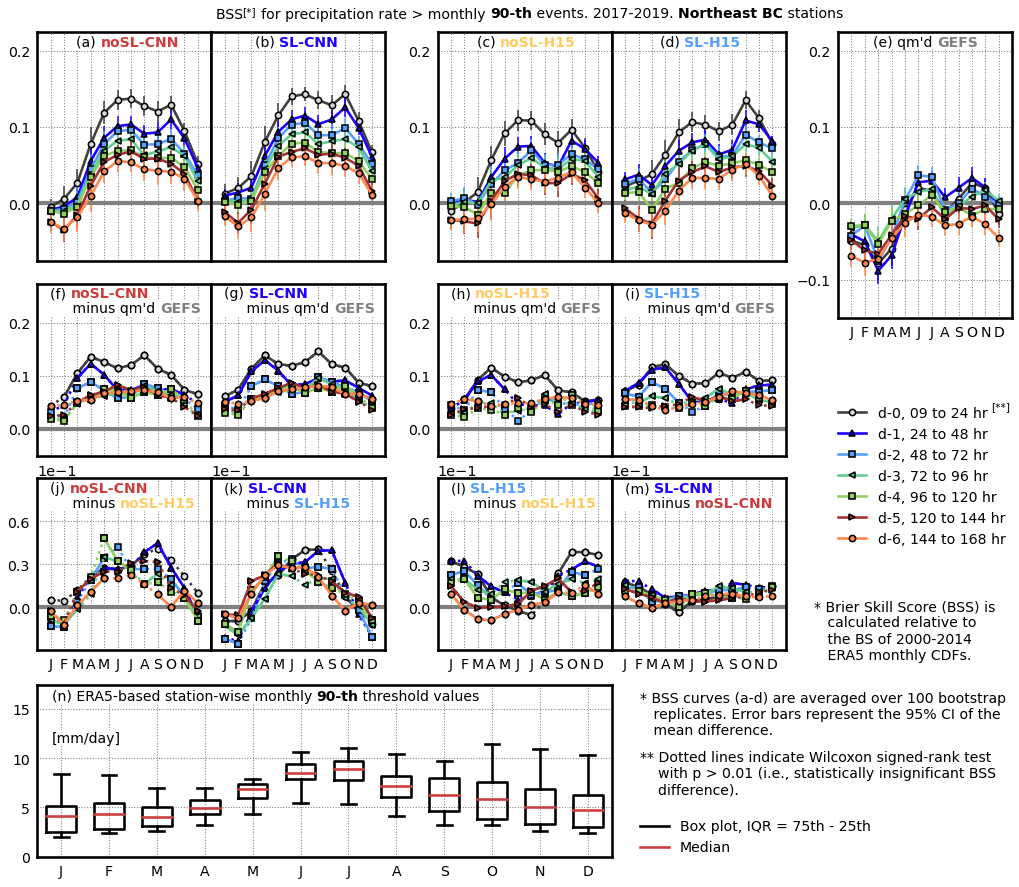

In [18]:
# 1st row
YLIM0 = [-0.075, 0.225]
YLIM1 = [-0.075, 0.225]
YLIM = YLIM1
YLIM_gfs = [-0.15, 0.225]

# 2nd row
YLIM_diff00 = [-0.05, 0.275]
YLIM_diff01 = [-0.05, 0.275]

# 3rd row
YLIM_diff1 = [-0.03, 0.09]
YLIM_diff2 = [-0.03, 0.09]

labels = ['d-0, 09 to 24 hr', 
          'd-1, 24 to 48 hr', 
          'd-2, 48 to 72 hr', 
          'd-3, 72 to 96 hr', 
          'd-4, 96 to 120 hr', 
          'd-5, 120 to 144 hr',
          'd-6, 144 to 168 hr']

h_ratio = np.array([1, 0.1, 0.75, 0.1, 0.75, 0.15, 0.75])
w_ratio = np.array([1, 1, 0.3, 1, 1, 0.3, 1])

fig = plt.figure(figsize=(13, 11), dpi=dpi_)
gs = gridspec.GridSpec(7, 7, height_ratios=h_ratio, width_ratios=w_ratio)

ax00 = plt.subplot(gs[0, 0]); ax01 = plt.subplot(gs[0, 1]); ax02 = plt.subplot(gs[0, 3]); ax03 = plt.subplot(gs[0, 4]);
ax10 = plt.subplot(gs[2, 0]); ax11 = plt.subplot(gs[2, 1]); ax12 = plt.subplot(gs[2, 3]); ax13 = plt.subplot(gs[2, 4]);
ax20 = plt.subplot(gs[4, 0]); ax21 = plt.subplot(gs[4, 1]); ax22 = plt.subplot(gs[4, 3]); ax23 = plt.subplot(gs[4, 4]);
ax_box = plt.subplot(gs[6, :4])

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

AX0 = [ax00, ax01, ax02, ax03]
AX1 = [ax10, ax11, ax12, ax13]
AX2 = [ax20, ax21, ax22, ax23]

AX_bss = [AX0,]
AX_diff = [AX1, AX2]

handle_title = []
handle_lines = []

wx = 1.0/w_ratio.sum()
dx = 4.6/w_ratio.sum()
hx = 1.0/h_ratio.sum()
locx = 1.0

AX_gfs = []
h_ = hx*(YLIM_gfs[1]-YLIM_gfs[0])/(YLIM[1]-YLIM[0]) 
AX_gfs.append(fig.add_axes([dx, locx-h_, wx, h_]))

AX_all = AX0 + AX1 + AX2 + AX_gfs

AX_left = [ax00, ax02, ax10, ax12, ax20, ax22, AX_gfs[0]]
AX_bottom = [ax20, ax21, ax22, ax23, AX_gfs[0]]

for i, ax in enumerate(AX_all):
    ax = gu.ax_decorate_box(ax)
    
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    
    ax.grid(linewidth=1.0, linestyle=':', color='0.5')
    ax.set_xlim([-1, 12])
    ax.set_xticks(fake_x)
    ax.axhline(0, xmin=0, xmax=1.0, linewidth=4.0, linestyle='-', color='0.5', zorder=2)
    
for ax in AX_left:
    ax.tick_params(labelleft=True)

for ax in AX_bottom:
    ax.tick_params(labelbottom=True)
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])

    
ax_box = gu.ax_decorate_box(ax_box)
ax_box.xaxis.set_tick_params(labelsize=fontsize)
ax_box.yaxis.set_tick_params(labelsize=fontsize)
ax_box.set_ylim([0, 17.5])
ax_box.grid(linewidth=1.0, linestyle=':', color='0.5')
ax_box.tick_params(labelleft=True)
ax_box.tick_params(labelbottom=True)
ax_box.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
handle_title.append(ax_box.text(0.025, 0.65, '[mm/day]', ha='left', va='bottom', 
                                fontsize=fontsize, transform=ax_box.transAxes))

methods_plot = ['bcnn', 'scnn', 'base', 'sl']

methods_diff1 = ['bcnn', 'scnn', 'sl', 'scnn']
methods_diff2 = ['base', 'sl', 'base', 'bcnn']

fontsize_list = [fontsize,]*5
fontweight_list = ['normal', 'bold', 'normal', 'bold', 'normal']

x_start0 = 0.225
y_start0 = 0.985

x_start1 = 0.2
y_start1 = 0.9825

x_start2 = 0.075
y_start2 = 0.9825

dd = 0.085
handle_title += gu.string_partial_format(fig, ax00, x_start0, y_start0, 'left', 'top', 
                                         ['(a) ', 'noSL-CNN', ], ['k', red], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax01, x_start0+0.025, y_start0, 'left', 'top', 
                                         ['(b) ', 'SL-CNN', ], ['k', blue], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax02, x_start0, y_start0, 'left', 'top', 
                                         ['(c) ', 'noSL-H15', ], ['k', orange], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax03, x_start0+0.05, y_start0, 'left', 'top', 
                                         ['(d) ', 'SL-H15', ], ['k', cyan], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, AX_gfs[0], x_start1, 1-(1-y_start1)*(hx/h_)+0.0025, 'left', 'top', 
                                         ["(e) qm'd ", 'GEFS'], ['k', gray], [fontsize,]*2,  ['normal', 'bold'])

handle_title += gu.string_partial_format(fig, ax10, x_start2, y_start2, 'left', 'top', 
                                         ['(f) ', 'noSL-CNN', ], ['k', red], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax10, x_start2, y_start2-dd, 'left', 'top', 
                                         ["     minus qm'd ", 'GEFS'], ['k', gray], fontsize_list, fontweight_list)

handle_title += gu.string_partial_format(fig, ax11, x_start2, y_start2, 'left', 'top', 
                                         ['(g) ', 'SL-CNN'], ['k', blue], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax11, x_start2, y_start2-dd, 'left', 'top', 
                                         ["     minus qm'd ", 'GEFS'], ['k', gray], fontsize_list, fontweight_list)

handle_title += gu.string_partial_format(fig, ax12, x_start2, y_start2, 'left', 'top', 
                                         ['(h) ', 'noSL-H15'], ['k', orange], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax12, x_start2, y_start2-dd, 'left', 'top', 
                                         ["     minus qm'd ", 'GEFS'], ['k', gray], fontsize_list, fontweight_list)

handle_title += gu.string_partial_format(fig, ax13, x_start2, y_start2, 'left', 'top', 
                                         ['(i) ', 'SL-H15'], ['k', cyan,], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax13, x_start2, y_start2-dd, 'left', 'top', 
                                         ["     minus qm'd ", 'GEFS'], ['k', gray], fontsize_list, fontweight_list)

handle_title += gu.string_partial_format(fig, ax20, x_start2, y_start2, 'left', 'top', 
                                         ['(j) ', 'noSL-CNN', ], ['k', red], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax20, x_start2, y_start2-dd, 'left', 'top', 
                                         ['     minus ', 'noSL-H15'], ['k', orange], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax21, x_start2, y_start2, 'left', 'top', 
                                         ['(k) ', 'SL-CNN'], ['k', blue], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax21, x_start2, y_start2-dd, 'left', 'top', 
                                         ['     minus ', 'SL-H15'], ['k', cyan], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax22, x_start2, y_start2, 'left', 'top', 
                                         ['(l) ', 'SL-H15'], ['k', cyan,], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax22, x_start2, y_start2-dd, 'left', 'top', 
                                         ['     minus ', 'noSL-H15'], ['k', orange], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax23, x_start2, y_start2, 'left', 'top', 
                                         ['(m) ', 'SL-CNN'], ['k', blue], fontsize_list, fontweight_list)
handle_title += gu.string_partial_format(fig, ax23, x_start2, y_start2-dd, 'left', 'top', 
                                         ['     minus ', 'noSL-CNN'], ['k', red], fontsize_list, fontweight_list)

# BSS and diff curves

AX_bss[0][0].set_ylim(YLIM0)
AX_bss[0][1].set_ylim(YLIM0)
AX_bss[0][2].set_ylim(YLIM1)
AX_bss[0][3].set_ylim(YLIM1)

AX_diff[0][0].set_ylim(YLIM_diff00)
AX_diff[0][1].set_ylim(YLIM_diff00)
AX_diff[0][2].set_ylim(YLIM_diff01)
AX_diff[0][3].set_ylim(YLIM_diff01)

AX_diff[1][0].set_ylim(YLIM_diff1)
AX_diff[1][1].set_ylim(YLIM_diff1)
AX_diff[1][2].set_ylim(YLIM_diff2)
AX_diff[1][3].set_ylim(YLIM_diff2)

AX_gfs[0].set_ylim(YLIM_gfs)
    
for d in range(7):
    AX_gfs[0].errorbar(fake_x, y=BSS_dict['gfs'][:, d], yerr=BSS_std_dict['gfs'][:, d],
                                       linewidth=2.5, linestyle=LS[d], color=C[d], marker=M[d], mfc=C_M[d], 
                                       ms=6, mec='k', mew=1.5, elinewidth=1.5, barsabove=False)
for m, method in enumerate(methods_plot):
    for d in range(7):
        AX_bss[0][m].errorbar(fake_x, y=BSS_dict['{}'.format(method)][:, d], yerr=BSS_std_dict['{}'.format(method)][:, d], 
                              linewidth=2.5, linestyle=LS[d], color=C[d], marker=M[d], mfc=C_M[d], ms=6, mec='k', mew=1.5,
                              elinewidth=1.5, barsabove=False)
        
        diff_temp = BSS_dict['{}'.format(method)]-BSS_dict['gfs']
        diff_temp_sig = np.copy(diff_temp)
        diff_temp_sig[np.abs(diff_temp_sig)<0.05] = np.nan
        
        AX_diff[0][m].plot(fake_x, diff_temp[:, d], linewidth=2.5, 
                           linestyle=':', color=C[d], marker=M[d], mfc=C_M[d], ms=6, mec='k', mew=1.5)
        AX_diff[0][m].plot(fake_x, diff_temp_sig[:, d], linewidth=2.5, 
                           linestyle='-', color=C[d], marker=M[d], mfc=C_M[d], ms=6, mec='k', mew=1.5)        
        
        diff_temp = BSS_dict['{}'.format(methods_diff1[m])]-BSS_dict['{}'.format(methods_diff2[m])]
        diff_p = BSS_wilcox['{}_{}'.format(methods_diff1[m], methods_diff2[m])]
        diff_temp_sig = np.copy(diff_temp)
        diff_temp_sig[diff_p>0.01] = np.nan

        AX_diff[1][m].plot(fake_x, diff_temp[:, d], linewidth=2.5, 
                           linestyle=':', color=C[d], marker=M[d], mfc=C_M[d], ms=6, mec='k', mew=1.5)
        AX_diff[1][m].plot(fake_x, diff_temp_sig[:, d], linewidth=2.5, 
                           linestyle='-', color=C[d], marker=M[d], mfc=C_M[d], ms=6, mec='k', mew=1.5)

dict_c = dict(marker='o', ms=8, mew=1.5, mfc='none')

for i in range(12):
    loc = i
    temp_ = 8*BCH_90th[i, FLAGs[2]]
    handle_boxp = ax_box.boxplot(temp_, positions=[loc,], flierprops=dict_c, widths=0.618)
    setBoxColors(handle_boxp, 'k', red, 2.5)
        
handle_lines = []
for d in range(7):
    handle_lines.append(mlines.Line2D([], [], linewidth=2.5, linestyle=LS[d], 
                                      color=C[d], marker=M[d], mfc=C_M[d], ms=6, 
                                      mec='k', mew=1.5, label=labels[d]))
    
for i in range(2):
    AX_bss[0][i].set_yticks([0, 0.1, 0.2])

for i in range(2, 4):
    AX_bss[0][i].set_yticks([0, 0.1, 0.2])
    
AX_gfs[0].set_yticks([-0.1, 0, 0.1, 0.2])

for i in [0, 1]:
    AX_diff[0][i].set_yticks([0, 0.1, 0.2,]);
    
for i in [2, 3]:
    AX_diff[0][i].set_yticks([0, 0.1, 0.2,]);
    
for i in [0, 1]:
    AX_diff[1][i].ticklabel_format(axis='y', scilimits=(-1, -1))
    AX_diff[1][i].set_yticks([0, 0.03, 0.06]);
    AX_diff[1][i].yaxis.offsetText.set_fontsize(14)

for i in [2, 3]:
    AX_diff[1][i].ticklabel_format(axis='y', scilimits=(-1, -1))
    AX_diff[1][i].set_yticks([0, 0.03, 0.06]);
    AX_diff[1][i].yaxis.offsetText.set_fontsize(14)
    
# ---------- title ---------- #
ax_t1 = fig.add_axes([0.5*(5.6-3.55)/5.6, 1.0, (3.55/5.6), 0.03])
ax_t1.set_axis_off()
handle_title += gu.string_partial_format(fig, ax_t1, 0, 1.0, 'left', 'top', 
                ['BSS    for precipitation rate > monthly ', '90-th', ' events. 2017-2019. ', 'Northeast BC', ' stations'], 
                ['k',]*5, fontsize_list, ['normal', 'bold', 'normal', 'bold', 'normal'])

handle_title.append(ax_t1.text(0.0435, 0.999, '[*]', ha='left', va='top', fontsize=10, transform=ax_t1.transAxes))

handle_title += gu.string_partial_format(fig, ax_box, 0.025, 0.975, 'left', 'top', 
                ['(n) ERA5-based station-wise monthly ', '90-th', ' threshold values'], 
                ['k',]*3, fontsize_list, ['normal', 'bold', 'normal'])

# ---------- legend and words ---------- #
pad = 0.0

# legend BSS lines
ax_lg1 = fig.add_axes([4.6/5.6, 0.925/3.6-pad, 1/5.6, 1/3.2])
ax_lg1.set_axis_off()
LG1 = ax_lg1.legend(handles=handle_lines, bbox_to_anchor=(1.035, 0.975), 
                    ncol=1, prop={'size':fontsize}, fancybox=False);
LG1.get_frame().set_facecolor('none')
LG1.get_frame().set_linewidth(0)
LG1.get_frame().set_alpha(1.0)

# words
handle_title.append(ax_lg1.text(0.88, 0.945, '[**]', ha='left', va='top', fontsize=10, transform=ax_lg1.transAxes))

ax_w1 = fig.add_axes([4.6/5.6-0.025, (0.7)/3.6-pad, 1/5.6+0.025, 0.375/3.2])
ax_w1.set_axis_off()
ax_w1.text(0, 1, '* Brier Skill Score (BSS) is\n   calculated relative to\n   the BS of 2000-2014\n   ERA5 monthly CDFs.', 
          ha='left', va='top', fontsize=fontsize, transform=ax_w1.transAxes);

ax_w2 = fig.add_axes([3.6/5.6-0.025, (0.3)/3.6-pad, 1/5.6+0.025, 0.375/3.2])
ax_w2.set_axis_off()
ax_w2.text(0, 1, '* BSS curves (a-d) are averaged over 100 bootstrap\n   replicates. Error bars represent the 95% CI of the\n   mean difference.', 
          ha='left', va='top', fontsize=fontsize, transform=ax_w2.transAxes);

ax_w3 = fig.add_axes([3.6/5.6-0.025, (-0.1)/3.6-pad, 1/5.6+0.025, 0.5/3.2])
ax_w3.set_axis_off()
ax_w3.text(0, 1, 
           '** Dotted lines indicate Wilcoxon signed-rank test\n    with p > 0.01 (i.e., statistically insignificant BSS\n    difference).', 
           ha='left', va='top', fontsize=fontsize, transform=ax_w3.transAxes);

# legend box plot
ax_lg2 = fig.add_axes([3.6/5.6-0.025, (0.0)/3.6-pad, 0.25, 0.06])
ax_lg2.set_axis_off()
LG2 = ax_lg2.legend([handle_boxp["boxes"][0], handle_boxp["medians"][0]],
                   ['Box plot, IQR = 75th - 25th', 'Median'], 
                   bbox_to_anchor=(1, 1), ncol=1, prop={'size':fontsize})
LG2.get_frame().set_facecolor('none')
LG2.get_frame().set_linewidth(0)
LG2.get_frame().set_alpha(1.0)
# -------------------------------------- #

for handle in handle_title:
    handle.set_bbox(dict(facecolor='w', pad=0.5, edgecolor='none', zorder=2))

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'AnEn_BCH_BSS_Northeast.png', format='png', **fig_keys)